# Tarea 6: YOLO

Aprendizaje de Máquina I, 2020

Oscar Esaú Peralta Rosales

Maestría en Ciencias con Especialidad en Computación


In [0]:
# !pip install tqdm

In [0]:
import os
import cv2
import pickle
import time
import xml

from collections import namedtuple
from IPython import display

import numpy as np
import tensorflow as tf

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

from tensorflow.keras.applications import vgg16
from tensorflow.keras.preprocessing import image
from tensorflow.keras import Model, layers, Input
from tensorflow.keras.optimizers import Adam

## Carga de datos

### Parseo de annotaciones

In [0]:
work_path = "/content/drive/My Drive/2do Semestre/Machine Learning/Tarea 6/data"
parent_folder = 'VOCdevkit/VOC2012'

In [0]:
annotations_folder = '%s/%s/Annotations' % (work_path, parent_folder)
image_sets_folder = '%s/%s/ImageSets' % (work_path, parent_folder)
jpeg_images_folder = '%s/%s/JPEGImages' % (work_path, parent_folder)
segmentation_class_folder = '%s/%s/SegmentationClass' % (work_path, parent_folder)
segmentation_object_folder = '%s/%s/SegmentationObject' % (work_path, parent_folder)

In [0]:
def parse_xml(file_path):
    doc = xml.dom.minidom.parse(file_path)
    obj_types = [x.firstChild.data for x in doc.getElementsByTagName('name')]
    return {
        'filename': doc.getElementsByTagName('filename')[0].firstChild.data,
        'folder': doc.getElementsByTagName('folder')[0].firstChild.data,
        'width': doc.getElementsByTagName('width')[0].firstChild.data,
        'height': doc.getElementsByTagName('height')[0].firstChild.data,
        'objects': [{
            'name': obj.getElementsByTagName('name')[0].firstChild.data,
			'xmin': int(obj.getElementsByTagName('xmin')[0].firstChild.data),
			'ymin': int(obj.getElementsByTagName('ymin')[0].firstChild.data),
			'xmax': int(obj.getElementsByTagName('xmax')[0].firstChild.data),
			'ymax': int(obj.getElementsByTagName('ymax')[0].firstChild.data),
        } for obj in doc.getElementsByTagName('object')],
        'object_types': {x.firstChild.data for x in doc.getElementsByTagName('name')},
    }

In [0]:
def save_object(path, filename, obj):
    with open(path + '/' + filename, 'wb') as fp:
        pickle.dump(obj, fp)

def load_object(path, filename):
    with open(path + '/' + filename, 'rb') as fp:
        obj = pickle.load(fp)
    return obj

In [0]:
# # Parse all the anotations if the object file does not exist

# annotations = [parse_xml(annotations_folder + '/' + annotation) for annotation in tqdm(os.listdir(annotations_folder))]
# save_object(work_path, 'annotations_all', annotations)

In [0]:
annotations = load_object(work_path, 'annotations_all')

In [0]:
# Filter only the annotations that have the objects required

# OBJ_TYPES = {'person', 'car', 'chair', 'dog'}
IMG_SHAPE = (224, 224)
OBJ_TYPES = {'car', 'dog'}
__OBJ_TYPES = list(OBJ_TYPES)

N_OBJ = len(OBJ_TYPES)

PROB_CLASS = np.zeros(len(OBJ_TYPES))

tmp = []
total = 0
for ann in annotations:
    if (ann['object_types'] & OBJ_TYPES):
        for obj in ann['objects']:
            if obj['name'] in OBJ_TYPES:
                PROB_CLASS[__OBJ_TYPES.index(obj['name'])] +=1
                total +=1
        tmp.append(ann)

annotations = tmp

PROB_CLASS /= total
len(annotations), PROB_CLASS

(2587, array([0.39070905, 0.60929095]))

### Conjunto de entrenamiento

#### Convertir de anotaciones a tensor de bboxes

In [0]:
def get_cell_from_center(cx, cy, S=7):
    """ Return the coords for the cell where the center belongs """
    cell_size = IMG_SHAPE[0] / S

    idx = x = 0
    while x <= cx:
        x += cell_size
        idx += 1
    x -= cell_size
    idx -= 1
    
    idy = y = 0
    while y <= cy:
        y += cell_size
        idy += 1
    y -= cell_size
    idy -= 1

    return (idy, idx), max(x, 0), max(y, 0), cell_size


def obj_to_bbox_tensor(obj, scaling_factor=(1.0, 1.0)):
    """ Returns a tuple with the where the first element are the cell index that
        the bbox belongs and the second element is list with the bbox as tensor
    """
    xmax = obj['xmax'] * scaling_factor[1]
    ymax = obj['ymax'] * scaling_factor[0]
    xmin = obj['xmin'] * scaling_factor[1]
    ymin = obj['ymin'] * scaling_factor[0]

    # Compute bbox center
    center_x = (xmax + xmin) / 2.0
    center_y = (ymax + ymin) / 2.0
    cell_id, cell_x, cell_y, cell_size = get_cell_from_center(center_x, center_y)
    x = (center_x - cell_x) / cell_size
    y = (center_y - cell_y) / cell_size
    
    # compute bbox dimensions
    w = (xmax - xmin) / IMG_SHAPE[1]
    h = (ymax - ymin) / IMG_SHAPE[0]
    
    # Class probabilities
    probs = [int(obj['name'] == otype) for otype in OBJ_TYPES]

    return np.array(cell_id), np.array([1, x, y, w, h, *probs])


def annotation_to_label(annotation, scaling_factor=(1.0, 1.0)):
    return [obj_to_bbox_tensor(obj, scaling_factor) for obj in annotation['objects'] if obj['name'] in OBJ_TYPES]

label_tmp = annotation_to_label(annotations[0])
annotations[0], label_tmp

({'filename': '2007_006444.jpg',
  'folder': 'VOC2012',
  'height': '375',
  'object_types': {'dog', 'person'},
  'objects': [{'name': 'dog',
    'xmax': 271.0,
    'xmin': 134.0,
    'ymax': 364.0,
    'ymin': 146.0},
   {'name': 'person',
    'xmax': 500.0,
    'xmin': 411.0,
    'ymax': 229.0,
    'ymin': 3.0}],
  'width': '500'},
 [(array([7, 6]),
   array([1.        , 0.328125  , 0.96875   , 0.61160714, 0.97321429,
          1.        , 0.        ]))])

#### Convertir de tensor de bboxes a coordenas en la imagen

In [0]:
Rectangle = namedtuple('Rectangle', ['x1', 'y1', 'x2', 'y2'])

def get_cell_coords_by_id(cell_id, S=7):
    """ Retorna las coordenadas de una celda """
    cell_dim = IMG_SHAPE[0] / S
    x1 = int(cell_id[1] * cell_dim)
    y1 = int(cell_id[0] * cell_dim)
    return Rectangle(x1, y1, int(x1 + cell_dim - 1), int(y1 + cell_dim - 1))


def bbox_tensor_to_coords(cell_id, bbox, S=7):
    """ Retorna las coordenadas correspondientes dentro de la imagen de un bbox predecido"""
    # Obtenemos las coordenadas de la celda
    cell_dim = IMG_SHAPE[0] / S
    cell_coords = get_cell_coords_by_id(cell_id)

    # Alto y ancho de respecto a la imagen
    w = abs(bbox[3])
    h = abs(bbox[4])
    width = w * IMG_SHAPE[1]
    height = h * IMG_SHAPE[0]

    # Centro del bbox respecto a la imagen
    x = bbox[1]
    y = bbox[2]
    bx = x * cell_dim + cell_coords.x1
    by = y * cell_dim + cell_coords.y1

    # Cordenadas del bbox
    x1, x2 = bx - width/2.0, bx + width/2.0
    y1, y2 = by - height/2.0, by + height/2.0

    return Rectangle(x1, y1, x2, y2)


coords_tmp = bbox_tensor_to_coords(label_tmp[0][0], label_tmp[0][1])
coords_tmp

Rectangle(x1=134.0, y1=146.0, x2=271.0, y2=364.0)

In [0]:
get_cell_coords_by_id((2, 0), S=14)

Rectangle(x1=0, y1=32, x2=15, y2=47)

#### Carga y creación de dataset de entrenamiento

In [0]:
def load_image(file_path, resize=None):
    """ Read and return a image with resize factor from the original size """
    img = cv2.imread(file_path)
    real_shape = img.shape
    
    if resize:
        img = cv2.resize(img, resize)
    resize_shape = img.shape
    
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    scaling_factor = (resize_shape[0] / real_shape[0], resize_shape[1] / real_shape[1])
    return img / 255.0, scaling_factor


def load_images(parent_path, filenames, resize=(244, 244)):
    """ Returns a list of images and a list with the scaling factor for the resize """
    images, scaling_factors = zip(*(load_image(parent_path + '/' + fname, resize=resize) for fname in filenames))
    return np.array(images), scaling_factors


def load_training_set(parent_path, annotations, resize=(244, 244), batch_size=64, randomnize=True):
    n_batchs = int(len(annotations) / batch_size)

    index = np.arange(batch_size * n_batchs)
    if randomnize:
        index = np.random.choice(index, index.shape[0], replace=False)
    index = index.reshape(n_batchs, -1)
    X = []
    Y = []
    for batch_index in tqdm(index):
        ann_range = [annotations[index] for index in batch_index]
        filenames = [ann['filename'] for ann in ann_range]
        images, scaling_factors = load_images(parent_path, filenames, resize=resize)
        labels = [annotation_to_label(ann, scaling_factor=scaling_factors[i]) for i, ann in enumerate(ann_range)]
        X.append(images)
        Y.append(labels)
        # yield images, labels
    return X, Y


In [0]:
# # For generators, avoid use generator to load data from drive on demand, it is too slow
# dataset = load_training_set(jpeg_images_folder, annotations, resize=IMG_SHAPE, batch_size=64, randomnize=True)
# x_train, y_train = next(dataset)

In [0]:
# # USe to load and save a new the train set 
# x_train, y_train = load_training_set(jpeg_images_folder, annotations, resize=IMG_SHAPE, batch_size=64, randomnize=True)
# save_object(work_path, 'x_train', x_train)
# save_object(work_path, 'y_train', y_train)

In [0]:
x_train = load_object(work_path, 'x_train')
y_train = load_object(work_path, 'y_train')

In [0]:
len(x_train), x_train[0].shape, len(y_train), len(y_train[0])

(40, (64, 224, 224, 3), 40, 64)

### Draw boxes

In [0]:
# function to draw bounding box on the detected object with class name

COLORS = np.random.randint(0, 255, size=(len(OBJ_TYPES), 3), dtype="int")

def draw_bounding_box(img, ann_obj=None, tensor_label=None, scaling_factor=(1.0, 1.0)):
    if ann_obj:
        x1 = int(ann_obj['xmax'] * scaling_factor[1])
        y1 = int(ann_obj['ymax'] * scaling_factor[0])
        x2 = int(ann_obj['xmin'] * scaling_factor[1])
        y2 = int(ann_obj['ymin'] * scaling_factor[0])
        class_name = ann_obj['name']
        if class_name not in OBJ_TYPES:
            return
    
    if tensor_label:
        cell_id, bbox_tensor = tensor_label
        coords = bbox_tensor_to_coords(cell_id, bbox_tensor)
        x1 = int(coords.x1)
        y1 = int(coords.y1)
        x2 = int(coords.x2)
        y2 = int(coords.y2)
        print(coords)
        class_name = __OBJ_TYPES[1] if bbox_tensor[-1] > bbox_tensor[-2] else __OBJ_TYPES[0]

    index = {v:i for i,v in enumerate(OBJ_TYPES)}[class_name]
    
    color = (int(COLORS[index][0]), int(COLORS[index][1]), int(COLORS[index][2]))
    # print(x1, y1, x2, y2, color)
    cv2.rectangle(img, (x1, y1), (x2, y2), color, 2)
    cv2.putText(img, class_name, (x1-10,y1-10), cv2.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)


Rectangle(x1=33.599999999999994, y1=79.3753753753754, x2=175.616, y2=174.89489489489492)


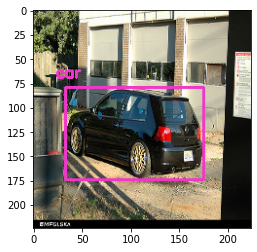

In [0]:
# Draw from train
index = 30

y = y_train[0][index]
img = x_train[0][index]

img = np.array(img*255, dtype=np.uint8) # To valid dimensions a type for opencv
for tensor_label in y:
    draw_bounding_box(img, tensor_label=tensor_label)

plt.imshow(img)

In [0]:
# # Draw by bbox_tensor
# index = 1

# file_path = "%s/%s" % (jpeg_images_folder, annotations[index]['filename'])
# img, scaling_factor = load_image(file_path, resize=IMG_SHAPE)
# label_tmp = annotation_to_label(annotations[index], scaling_factor=scaling_factor)

# img = np.array(img*255, dtype=np.uint8) # To valid dimensions a type for opencv
# for tensor_label in label_tmp:
#     draw_bounding_box(img, tensor_label=tensor_label)

# plt.imshow(img)

In [0]:
# # Draw by annotation
# index = 1
# file_path = "%s/%s" % (jpeg_images_folder, annotations[index]['filename'])
# img, scaling_factor = load_image(file_path, resize=IMG_SHAPE)
# a = annotations[index]

# img = np.array(img*255, dtype=np.uint8) # To valid dimensions a type for opencv
# for obj in a['objects']:
#     draw_bounding_box(img, ann_obj=obj, scaling_factor=scaling_factor)

# plt.imshow(img)

## Modelo

In [0]:
model_vgg = vgg16.VGG16(weights='imagenet', include_top=False, input_shape=(224, 224, 3))
# model_vgg = vgg16.VGG16(weights='imagenet', include_top=False)

58892288/58889256 [==============================] - 1s 0us/step


In [0]:
# pred = model_vgg.predict(x_train)
# pred.shape

In [0]:
def build_yolo_model(model_vgg):
    input_shape = Input(shape=model_vgg.layers[-1].output_shape[1:])
    x = layers.Conv2D(filters=512, kernel_size=(5, 5), padding='same')(input_shape)
    Y = layers.Conv2D(filters=12, kernel_size=(3, 3), padding='same')(x)
    # Y = layers.Conv2D(filters=12, kernel_size=(3, 3), padding='same', activation='sigmoid')(x)
    return Model(inputs=input_shape, outputs = Y, name ='yolo')

model_yolo = build_yolo_model(model_vgg)

## Costo y optimización

In [0]:
BBOX = namedtuple('BBOX', ['c', 'x', 'y', 'w', 'h', 'probs'])

def get_rectangle_area(rec):
    """ Returns the area of 2 rectangles """
    return (rec.x2 - rec.x1) * (rec.y2 - rec.y1)


def get_intersection(rec1, rec2):
    """ Returns the area of the intersection of 2 rectangles """
    x1 = max(rec1.x1, rec2.x1)
    y1 = max(rec1.y1, rec2.y1)
    x2 = min(rec1.x2, rec2.x2)
    y2 = min(rec1.y2, rec2.y2)
    return get_rectangle_area(Rectangle(x1, y1, x2, y2))


def get_OUI(cell_id, bbox_real, bbox_pred):
    """ Returns the OUI for a real bbox and a pred bbox """
    coords_real = bbox_tensor_to_coords(cell_id, list(bbox_real))
    coords_pred = bbox_tensor_to_coords(cell_id, list(bbox_pred))
    
    intersection = get_intersection(coords_real, coords_pred)
    union = get_rectangle_area(coords_real) + get_rectangle_area(coords_pred) - intersection

    return intersection / union


def get_bbox_params_from_output(cell_id, output, nparams=5, nobjs=2):
    probs = output[tuple(cell_id)][-nobjs:]

    cxywh = output[tuple(cell_id)][:nparams]
    bbox1 = BBOX(*cxywh, probs)

    cxywh = output[tuple(cell_id)][nparams:nparams*2]
    bbox2 = BBOX(*cxywh, probs)

    return bbox1, bbox2


def get_bbox_params(bbox_tensor, nparams=5, nobjs=2):
    probs = bbox_tensor[-nobjs:]
    cxywh = bbox_tensor[:nparams]
    bbox = BBOX(*cxywh, probs)
    return bbox


def get_best_bbox(cell_id, bbox_real, output):
    """ Returns the bbox that maximize the OUI """
    bbox1, bbox2 = get_bbox_params_from_output(cell_id, output)

    # Calculamos el OUI para las dos bbox predecidos
    OUI_b1 = get_OUI(cell_id, bbox_real, bbox1)
    OUI_b2 = get_OUI(cell_id, bbox_real, bbox2)
    
    # Nos quedamos con el que tenga mayor OUI
    bboxJ, oui = (bbox1, OUI_b1) if OUI_b1 > OUI_b2 else (bbox2, OUI_b2)

    return bboxJ, oui


def l_loss(real_output, output, lmda1=5, lmda2=5, lmda3=0.5, S=7):
    cells = []
    cost_pos = 0.0
    cost_form = 0.0
    cost_conf = 0.0
    for cell_id, bbox_tensors in real_output:
        if tuple(cell_id) in cells:
            # un objeto por celda
            continue
        cells.append(tuple(cell_id))
        bbox_real = get_bbox_params(bbox_tensors)
        bbox_pred, oui = get_best_bbox(cell_id, bbox_real, output)
        # Costo posición
        cost_pos +=(bbox_pred.x - bbox_real.x)**2 + (bbox_pred.y - bbox_real.y)**2
        # Costo forma
        cost_form += (np.sqrt(abs(bbox_pred.w)) - np.sqrt(bbox_real.w))**2
        cost_form += (np.sqrt(abs(bbox_pred.h)) - np.sqrt(bbox_real.h))**2
        # Costo configuración
        index = np.argmax(bbox_pred.probs)
        cost_conf += (bbox_pred.c - bbox_pred.probs[index]*oui)**2
        cost_conf += (bbox_pred.probs[index] - bbox_real.probs[index])**2
    
    cost_conf_noobj = 0.0
    for i in range(S):
        for j in range(S):
            cell_id = (i,j)
            if cell_id in cells:
                continue
            cost_conf_noobj += (bbox_pred.c)**2
    
    return lmda1*cost_pos + lmda2*cost_form + cost_conf + lmda3*cost_conf_noobj


def yolo_loss(real_outputs, pred_outputs):
    losses = []
    for i in range(len(real_outputs)):
        real_output = real_outputs[i]
        pred_output = pred_outputs[i]
        losses.append(l_loss(real_output, pred_output))

    return tf.convert_to_tensor(losses)

## Entrenamiento

### Checkpoints

In [0]:
def checkpoint_save(parent_folder, folder='models'):
    full_path = parent_folder + '/' + folder
    w = model_yolo.get_weights()
    model_name = str(time.asctime()) + '.model'
    save_object(full_path, model_name, w)
    save_object(full_path, 'last.model', w)

def checkpoint_restore(parent_folder, folder='models'):
    full_path = parent_folder + '/' + folder
    w = load_object(full_path, 'last.model')
    model_yolo.set_weights(w)


# checkpoint_save(work_path)
# checkpoint_restore(work_path)

In [0]:
def generate_and_save_images(imgs, save=True):
    
    preds = model_yolo.predict(model_vgg.predict(imgs))

    def find_box(pred):
        cell_id_max = (0,0)
        c_max = pred[cell_id_max][0], pred[cell_id_max][5]
        for i in range(7):
            for j in range(7):
                cell_id = (i,j)
                # print(pred[cell_id])
                c = pred[cell_id][0], pred[cell_id][5]
                if np.max(c) > np.max(c_max):
                    cell_id_max = cell_id
                    c_max = c

        index = 0 if c_max[0] > c_max[1] else 5
        bbox = pred[cell_id_max][index:index+5]
        probs = pred[cell_id_max][-2:]
        return  cell_id_max, [*bbox, *probs]

    fig = plt.figure(figsize=(12, 12))
    for i in range(preds.shape[0]):
        img = imgs[i]
        pred = preds[i]
        img = np.array(img*255, dtype=np.uint8) # To valid dimensions a type for opencv
        cell_id, bbox = find_box(pred)
        print(cell_id, bbox)
        draw_bounding_box(img, tensor_label=(cell_id, bbox))
        plt.subplot(3, 3, i+1)
        plt.imshow(img)
        plt.axis('off')

    if save:
        plt.savefig('%s.png' % time.asctime())

    plt.show()


(1, 0) [0.1826069, 0.12658772, -0.08712277, 32.472446, 36.75551, 0.19585602, -1.953423]
Rectangle(x1=-3632.863194465637, y1=-4087.404871940613, x2=3640.9648084640503, y2=4145.829014778137)
(1, 2) [0.18233056, -0.11198463, 0.31477585, 0.9841883, -6.436347, 0.42136317, -2.6904287]
Rectangle(x1=-49.812599897384644, y1=-678.7980375289917, x2=170.64558339118958, y2=762.9436922073364)
(2, 4) [0.26002973, 0.73207605, 0.31294575, -31.79536, 32.975574, 0.13362406, -9.021103]
Rectangle(x1=-3409.653949737549, y1=-3619.2500791549683, x2=3712.5068168640137, y2=3767.2786073684692)
(2, 2) [0.27634186, 0.063874386, -0.08931143, -58.416214, 4.8546834, 0.4511558, -6.2508297]
Rectangle(x1=-6476.571986436844, y1=-482.58250641822815, x2=6608.659947156906, y2=604.8665750026703)
(2, 3) [0.4013039, 0.29615292, 0.7519536, 0.93616533, 39.243176, 0.034992147, -15.079271]
Rectangle(x1=0.6263761520385742, y1=-4307.173141479492, x2=210.327410697937, y2=4483.29817199707)
(1, 0) [0.2807145, -0.14801964, 0.21107157, 8

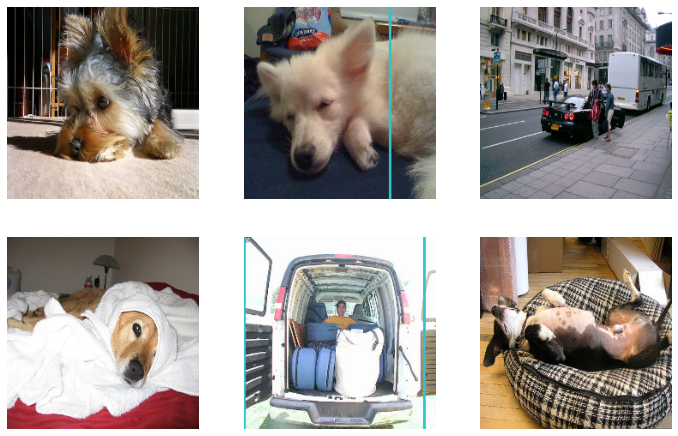

In [0]:
# Imágenes para pruebas
checkpoint_restore(work_path)

IMG_TEST_FILES = ['car.jpg', 'dog.jpeg']
IMG_TEST = np.array([load_image(filename, resize=(224, 224))[0] for filename in IMG_TEST_FILES])
IMG_TEST.shape
generate_and_save_images(x_train[0][2:8])
# generate_and_save_images(IMG_TEST)

### Optimizadores

In [0]:
yolo_optimizer = Adam(1e-3)

In [0]:
# @tf.function
def train_step(train, labels):
    with tf.GradientTape() as tape:
        yolo_out = model_yolo(train, training=True)
        loss = yolo_loss(labels, yolo_out)
    gradients = tape.gradient(loss, model_yolo.trainable_variables)
    yolo_optimizer.apply_gradients(zip(gradients, model_yolo.trainable_variables))
    return tf.reduce_mean(loss)

In [0]:
def train(x_train, y_train, epochs):
    for epoch in range(epochs):
        start = time.time()
        print ('Epoch {} started'.format(epoch + 1))
        losses = []
        for i in tqdm(range(len(x_train))):
            x_btch = model_vgg.predict(x_train[i])
            y_btch = y_train[i]
            loss = train_step(x_btch, y_btch)
            losses.append(loss)
        
        checkpoint_save(work_path)
        display.clear_output(wait=True)
        generate_and_save_images(IMG_TEST)
        plt.plot(losses)
        plt.show()
        print ('Time for epoch {} is {} sec'.format(epoch + 1, time.time()-start))

    checkpoint_save(work_path)
    # display.clear_output(wait=True)
    generate_and_save_images(IMG_TEST)

(1, 6) [0.6502383, 0.75601065, 0.6445255, -31.122925, 8.604763, 0.60708356, -41.362843]
Rectangle(x1=-3269.57523727417, y1=-911.108642578125, x2=3701.95991897583, y2=1016.3582763671875)
(2, 5) [1.3860183, 1.5430931, 1.4431905, -121.34772, -22.773008, 1.5319881, -81.148056]
Rectangle(x1=-13381.565357208252, y1=-2440.3948402404785, x2=13800.323314666748, y2=2660.7590293884277)


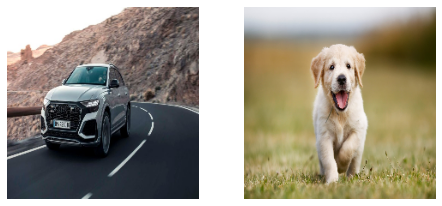

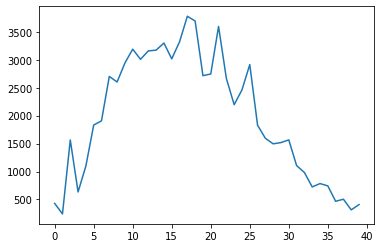

Time for epoch 1 is 72.5302062034607 sec
(1, 6) [0.6502383, 0.75601065, 0.6445255, -31.122925, 8.604763, 0.60708356, -41.362843]
Rectangle(x1=-3269.57523727417, y1=-911.108642578125, x2=3701.95991897583, y2=1016.3582763671875)
(2, 5) [1.3860183, 1.5430931, 1.4431905, -121.34772, -22.773008, 1.5319881, -81.148056]
Rectangle(x1=-13381.565357208252, y1=-2440.3948402404785, x2=13800.323314666748, y2=2660.7590293884277)


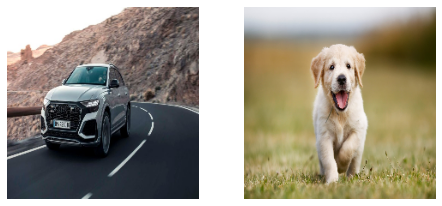

In [0]:
# Recover last checkpoint
checkpoint_restore(work_path)

EPOCHS = 1

train(x_train, y_train, EPOCHS)

(3, 6) [0.5682936, 1.0933492, 0.9819401, -52.480125, 0.05771611, -0.18197805, -43.527157]
Rectangle(x1=-5650.7868728637695, y1=120.95787870883942, x2=6104.7612228393555, y2=133.88628709316254)
(3, 6) [0.26602334, 0.285417, 0.5636167, -32.721855, 0.6316404, -0.6872825, -43.2076]
Rectangle(x1=-3463.7144346237183, y1=43.292012214660645, x2=3865.9811220169067, y2=184.77945613861084)
(1, 6) [0.401678, -1.3318533, 1.3942053, 3.195078, 10.28128, -0.10722632, -35.813156]
Rectangle(x1=-208.4680290222168, y1=-1074.8887405395508, x2=507.22941970825195, y2=1228.1178817749023)
(3, 6) [0.443345, 0.92755646, 0.76893604, 2.4361293, 10.753013, 0.019725256, -37.722725]
Rectangle(x1=-51.1646785736084, y1=-1083.7314643859863, x2=494.5282917022705, y2=1324.9433708190918)
(4, 4) [0.4837527, -5.350047, 5.523695, -24.65755, 38.551136, -0.1482479, -125.03599]
Rectangle(x1=-2804.847198486328, y1=-4012.968994140625, x2=2718.4441833496094, y2=4622.4854736328125)
(2, 6) [0.52140605, 0.78567994, 0.9400235, -38.423,

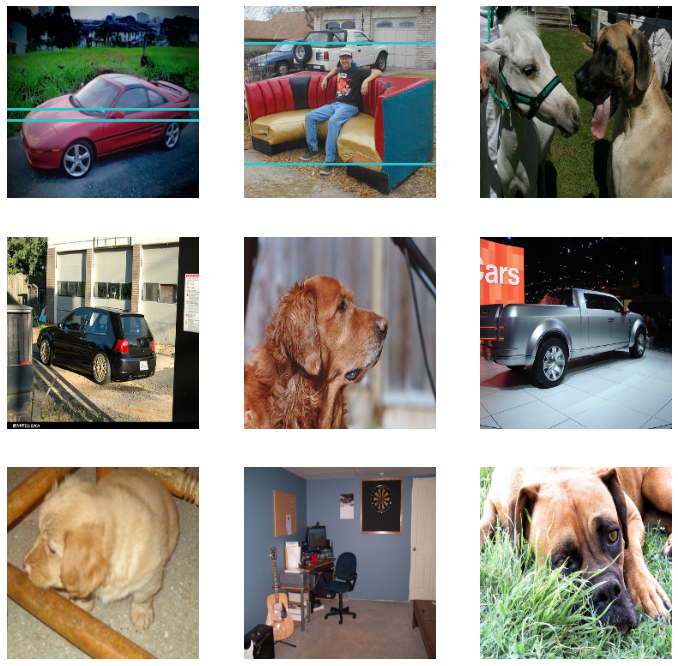

In [0]:
generate_and_save_images(x_train[0][27:36])
# generate_and_save_images(IMG_TEST)

No pude lograr obtener muy buenos resultados.

Durante los entrenamientos la función de costo logro bajar a costos entre los 300 y 500, pero de ahi se estancaba. En algunas imágenes parece mostrar resultados pero no son los deseados.